# Autocatalytic reaction
Next, we focus on an autocatalytic system defined by
$$
\xrightarrow{C^b_i} \mathrm{A}_i \xrightarrow{C^d_i} \\
\mathrm{A}_i \xrightarrow{c^a} \mathrm{A}_i + \mathrm{A}_i \\
\mathrm{A}_i \xrightarrow{c^t} \mathrm{B} \\
\mathrm{B}_i \xrightarrow{c^t} \mathrm{A}. \\
$$
Here we consider $C^b_i$ and $C^d_i$ to be randomly distributed across the population, while the autocatalytic rate $c^a$ and transport rate $c^t$ are fixed.

## Symmetry-reduced moment dynamics
This system can be described with a symmetry-reduced model of up to the second order using $\hat{K}_{eq}=12$ differential equations regardless of the population size. The system is non-closed due to the extrinsic noise of the birth and death reaction rate constants. To solve for the moment dynamics, we used a lognormal moment-closure approximation (MA). We solved for moment dynamics at different population sizes $N=[5, 10, 50]$ and transport rates $c^t = [0, 0.01, 0.1]$.

In [1]:
# Import required modules.
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from autocatalytic_functions import * 

# Number of cells in the popuation.
N_list = [5, 10, 50]

# Transport of signalling molecule.
k_list = [0, 0.01, 0.1]

# Solve moments for different N and kt.
u_stack = np.zeros(12)
labels = np.zeros(2)
for N in N_list:
    for k in k_list:
        # A, Ss
        i_mean = np.array([20, 1]) 
        i_std = np.array([5, 0])
        # kb, ka, kd, kout, kin
        k_mean = np.array([1, 0.08, 0.1, k, k])
        k_std = np.array([0.1, 0, 0.005, 0, 0])
        u = solve_moments(N, i_mean, i_std, k_mean, k_std)
        u_stack = np.vstack((u_stack,u['y'].transpose()))    
        labels = np.vstack((labels,np.array([N,k])))
u_stack = u_stack[1:,:]
labels = labels[1:,:]

# Reformat into Pandas Dataframe.
u_df = pd.DataFrame(u_stack, columns=['A0','Ss','A0**2',
                                      'A0*Ss','A0*A1','A0*kb0',
                                      'A0*kd0','A0*kb1','A0*kd1',
                                      'Ss**2','Ss*kb0','Ss*kd0'])
u_df.index = np.tile(u['t'],len(N_list)*len(k_list))
u_df['Time'] = np.tile(u['t'],len(N_list)*len(k_list))
u_df['N'] = np.repeat(N_list, len(k_list)*len(u['t']))
u_df['k'] = np.tile(np.repeat(k_list, len(u['t'])), len(N_list))
u_df['Std(A0)'] = ((u_df['A0**2']-u_df['A0']**2))**0.5
u_df['Std(Ss)'] = ((u_df['Ss**2']-u_df['Ss']**2))**0.5
u_df['CV(A0)'] = u_df['Std(A0)']/u_df['A0']
u_df['Var(A0-A1)'] = (2*u_df['A0**2']-2*u_df['A0*A1'])
u_df['Var(A0)'] = u_df['A0**2']-u_df['A0']**2

# Save moment results.
u_df.to_csv('autocatalytic_moments.csv', sep = ';')

## Stochastic simulations
We compared the approximated moment dynamics with moments calculated from exact SSA runs for the same sets of $N$ and $c^t$. 95% confidence intervals were calculated by bootstrapping the SSA results.

In [2]:
# Import required modules.
import pandas as pd
import numpy as np
from autocatalytic_functions import * 

# Number of cells in the popuation.
N_list = [5, 10, 50]

# Transport of signalling molecule.
k_list = [0, 0.01, 0.1]

# Run SSAs and compile into dataframe.
runs = 200 # We used 1000 for our results. It just takes longer to finish.
s_df = pd.DataFrame()
for N in N_list: # Different population sizes.
    s_stack_df = runSSA(N, 0.1, runs)
    s_df = s_df.append(s_stack_df, sort='True')
s2_df = pd.DataFrame()
for k in [0, 0.01]: # Different signalling molecule transport rates.
    s2_stack_df = runSSA(10, k, runs)
    s2_df = s2_df.append(s2_stack_df, sort='True')
s3_df = pd.concat([s_df,s2_df], sort = False, axis = 0)

# Bootstrap results.
pts = 100
bs_set = pd.DataFrame(columns={'lower','upper','N','k','typ'})
for N in N_list:
    for k in k_list:
        sub_s = s3_df[(s3_df['N']==N) & (s3_df['k']==k)]
        if np.shape(sub_s)[0] != 0:
            sub_s.insert(54, '(A0-A1)^2', (sub_s['A0']-sub_s['A1'])**2)
            a = bootstrapping(sub_s, 'mean', runs, pts, ['A0'])
            b = bootstrapping(sub_s, 'var', runs, pts, ['A0'])
            c = bootstrapping(sub_s, 'cv', runs, pts, ['A0'])
            d = bootstrapping(sub_s, 'pv', runs, pts, ['(A0-A1)^2','A0','A1'])
            bootstrap = pd.concat((a,b,c,d), sort = False)
            bootstrap['N'] = np.repeat(N, np.shape(bootstrap)[0])
            bootstrap['k'] = np.repeat(k, np.shape(bootstrap)[0])
            bootstrap['typ'] = np.repeat(['mean','var','cv','pv'], np.shape(bootstrap)[0]/4)
            bs_set = pd.concat((bs_set, bootstrap), sort = False)

# Save results.
s3_df.to_csv('autocatalytic_ssa.csv', sep = ';')
bs_set.to_csv('autocatalytic_bs.csv', sep = ';')

## Plot results
This section recreates Figure 4 in the paper from the saved results.

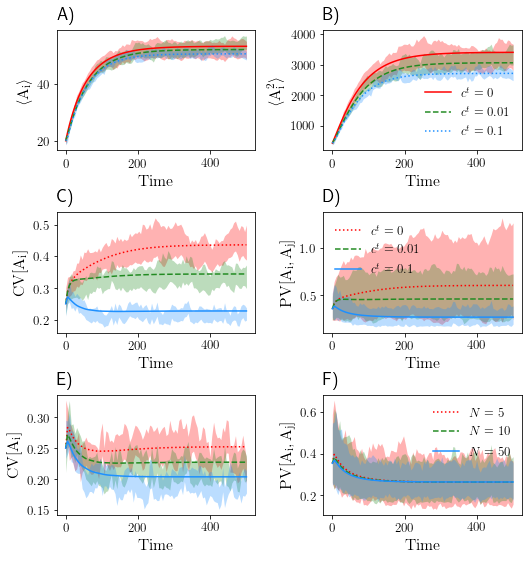

In [3]:
# Import required modules.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Open saved results.
u_df = pd.read_csv('autocatalytic_moments.csv', sep = ';', index_col=0 )
bs_set = pd.read_csv('autocatalytic_bs.csv', sep = ';', index_col=0)

# Set figure format.
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['legend.fontsize'] = 13
matplotlib.rcParams['axes.titlepad'] = 10

plt.figure(figsize=(7.5,7.9))
bg_color = ['red', 'forestgreen', 'dodgerblue']
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
pts = 100

# Plot results.
ax1 = plt.subplot(3,2,1)
N = 10
s = 'A0'   
linestyles = ['-','--',':']
for idx,k in enumerate([0, 0.01, 0.1]):
    sub_u = u_df[(u_df['N']==N) & (u_df['k']==k)]
    ci = bs_set[(bs_set['N']==N) & (bs_set['k']==k) & (bs_set['typ']=='mean')]
    ax1.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[idx], alpha =0.3, linewidth=0)
    ax1.plot(sub_u['Time'], sub_u[s], color = bg_color[idx], linestyle = linestyles[idx], linewidth = 1.5, label = '$c^t = '+ str(k) + '$')
ax1.set_xlabel('$\mathrm{Time}$')
ax1.set_ylabel(r'$\langle \mathrm{A_i}\rangle$')
ax1.set_title('A)', loc = 'left')

ax1 = plt.subplot(3,2,2)
N = 10
s = 'A0**2'
for idx,k in enumerate([0, 0.01, 0.1]):
    sub_u = u_df[(u_df['N']==N) & (u_df['k']==k)]
    ci = bs_set[(bs_set['N']==N) & (bs_set['k']==k) & (bs_set['typ']=='var')]
    ax1.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[idx], alpha =0.3, linewidth=0)
    ax1.plot(sub_u['Time'], sub_u[s], color = bg_color[idx], linestyle = linestyles[idx], linewidth = 1.5, label = '$c^t = '+str(k)+'$') 
ax1.set_xlabel('$\mathrm{Time}$')
ax1.set_ylabel(r'$\langle\mathrm{A_i^2}\rangle$')
ax1.set_title('B)', loc = 'left')
plt.legend(loc = 'lower right', frameon = False)

plt.subplot(3,2,3)
styles = [':','--','-']
for idx, k in enumerate([0, 0.01, 0.1]):
    sub_u = u_df[(u_df['N']==10) & (u_df['k']==k)]
    ci = bs_set[(bs_set['N']==N) & (bs_set['k']==k) & (bs_set['typ']=='cv')]
    plt.fill_between(sub_u['Time'], ci['lower'],ci['upper'], color = bg_color[idx], zorder = 0, label = '_nolegend_', alpha =0.3, linewidth=0)
    plt.plot(sub_u['Time'], sub_u['CV(A0)'], color = bg_color[idx], linestyle = styles[idx], label = '$c^t = '+ str(k) + '$')
plt.ylabel('$\mathrm{CV[A_i]}$')
plt.xlabel('$\mathrm{Time}$')
plt.title('C)', loc = 'left')

plt.subplot(3,2,4)
for idx, k in enumerate([0, 0.01, 0.1]):
    sub_u = u_df[(u_df['N']==10) & (u_df['k']==k)]
    ci = bs_set[(bs_set['N']==N) & (bs_set['k']==k) & (bs_set['typ']=='pv')]
    plt.fill_between(sub_u['Time'], ci['lower'],ci['upper'], color = bg_color[idx], zorder = 0, label = '_nolegend_', alpha =0.3, linewidth=0)
    plt.plot(sub_u['Time'], (sub_u['Var(A0-A1)']/(sub_u['A0']**2))**0.5, color = bg_color[idx], linestyle = styles[idx], label = '$c^t = '+ str(k) + '$')
plt.ylabel('$\mathrm{PV[A_i,A_j]}$')
plt.xlabel('$\mathrm{Time}$')
plt.title('D)', loc = 'left')
plt.legend(loc = 'upper left', frameon = False)

plt.subplot(3,2,5)
styles = [':','--','-']
for idx, N in enumerate([5,10,50]):
    sub_u = u_df[(u_df['N']==N) & (u_df['k']==0.1)]
    ci = bs_set[(bs_set['N']==N) & (bs_set['k']==k) & (bs_set['typ']=='cv')]
    plt.fill_between(sub_u['Time'], ci['lower'],ci['upper'], color = bg_color[idx], zorder = 0, label = '_nolegend_', alpha =0.3, linewidth=0)
    plt.plot(sub_u['Time'], sub_u['CV(A0)'], color = bg_color[idx], linestyle = styles[idx], label = '$N = '+ str(N) + '$')
plt.ylabel('$\mathrm{CV[A_i]}$')
plt.xlabel('$\mathrm{Time}$')
plt.title('E)', loc = 'left')

plt.subplot(3,2,6)
for idx, N in enumerate([5,10,50]):
    sub_u = u_df[(u_df['N']==N) & (u_df['k']==0.1)]
    ci = bs_set[(bs_set['N']==N) & (bs_set['k']==k) & (bs_set['typ']=='pv')]
    s_var = (sub_s.groupby('time').mean()['(A0-A1)^2']/(sub_s.groupby('time').mean()['A0']*sub_s.groupby('time').mean()['A1']))**0.5
    plt.fill_between(sub_u['Time'], ci['lower'],ci['upper'], color = bg_color[idx], zorder = 0, label = '_nolegend_', alpha =0.3, linewidth=0)
    plt.plot(sub_u['Time'], (sub_u['Var(A0-A1)']/(sub_u['A0']**2))**0.5, color = bg_color[idx], linestyle = styles[idx], label = '$N = '+ str(N) + '$')
plt.ylabel('$\mathrm{PV[A_i,A_j]}$')
plt.xlabel('$\mathrm{Time}$')
plt.title('F)', loc = 'left')
plt.legend(loc = 'upper right', frameon = False)
plt.tight_layout(h_pad=-0.05)

plt.savefig('autocatalytic.pdf', pad_inches=0)
plt.show()

This section recreates Figure 5 in the paper from the saved results.

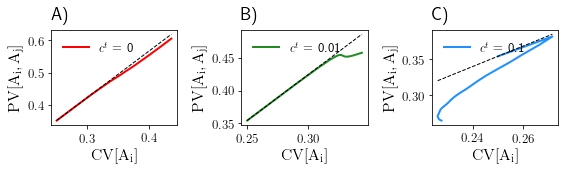

In [4]:
# Import required modules.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Open saved results.
u_df = pd.read_csv('autocatalytic_moments.csv', sep = ';', index_col=0 )

# Set figure format.
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['legend.fontsize'] = 13
matplotlib.rcParams['axes.titlepad'] = 10

# Plot results.
plt.figure(figsize=(8,2.5))
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

titles = ['A','B','C','D','E','F']
bg_color = ['red', 'forestgreen', 'dodgerblue']

N = 10
k_list = [0, 0.01, 0.1]

for idx,k in enumerate(k_list):
    plt.subplot(1,3,idx+1)
    cv = u_df[(u_df['N']==N) & (u_df['k']==k)]['CV(A0)']
    pv = (u_df[(u_df['N']==N) & (u_df['k']==k)]['Var(A0-A1)']/u_df[(u_df['N']==N) & (u_df['k']==k)]['A0']**2)**0.5
    xlims = np.linspace(np.min(cv), np.max(cv),10)
    plt.plot(xlims,xlims*(2**0.5), color = 'black', ls = '--', lw = 1, zorder = 1, label = '_nolegend_')
    plt.plot(cv,pv, label = '$c^t$ = ' + str(k), color = bg_color[idx], lw = 2, zorder = 0)
    plt.title(titles[idx+0]+')', loc = 'left')
    plt.legend(loc = 2, frameon = False)
    plt.ylabel('$\mathrm{PV[A_i,A_j]}$')
    plt.xlabel('$\mathrm{CV[A_i]}$')

plt.tight_layout()
plt.savefig('cv_vs_pv_autocat.pdf', pad_inches=0)
plt.show()